<a href="https://colab.research.google.com/github/sotolagg/Optimizing-e-commerce-conversion-rate-with-dynamic-pricing-techniques/blob/main/ETS_LSTM_Hybrid_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [ ]:
import pandas as pd 
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import numpy as np
from numpy import asarray
from numpy import sqrt 
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import calendar
from statsmodels.tsa.api import ExponentialSmoothing
from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn import preprocessing
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


In [ ]:
df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/champagne.xlsx')
df.head()

,Month,Sales
0,2010-01-01,2815
1,2010-02-01,2672
2,2010-03-01,2755
3,2010-04-01,2721
4,2010-05-01,2946


In [ ]:
dates = pd.date_range(start='2010-01-01', freq='MS', periods=len(df))
df.set_index(dates,inplace=True)
sales_ts = df['Sales']
data = pd.DataFrame(sales_ts.copy())
data.head()

,Sales
2010-01-01,2815
2010-02-01,2672
2010-03-01,2755
2010-04-01,2721
2010-05-01,2946


In [ ]:
series = data['Sales'].tolist()
size = int(len(series) * 0.8)
train, test = series[0:size], series[size:len(series)]
print('Train data length :',len(train))
print('Test  data length :',len(test))

Train data length : 84
Test  data length : 21


predicted=2301.958423, expected=3934.000000
predicted=3087.134979, expected=3162.000000
predicted=3632.087872, expected=4286.000000
predicted=4011.007980, expected=4676.000000
predicted=3489.115856, expected=5010.000000
predicted=4489.457576, expected=4874.000000
predicted=4568.619442, expected=4633.000000
predicted=2268.311439, expected=1659.000000
predicted=5579.819960, expected=5951.000000
predicted=7012.468083, expected=6981.000000
predicted=10507.284719, expected=9851.000000
predicted=13520.024039, expected=12670.000000
predicted=3993.750651, expected=4348.000000
predicted=3516.313769, expected=3564.000000
predicted=4485.915737, expected=4577.000000
predicted=4831.615169, expected=4788.000000
predicted=4943.535972, expected=4618.000000
predicted=4979.016249, expected=5312.000000
predicted=4776.134846, expected=4298.000000
predicted=1985.158968, expected=1413.000000
predicted=6011.803102, expected=5877.000000


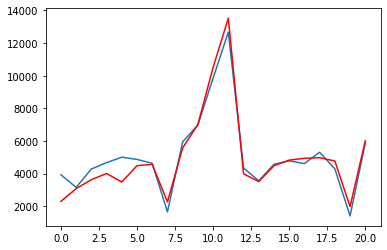

In [ ]:
""" ETS Rolling Forecast """
predicted, resid_test = [], []
history = train
for t in range(len(test)):
    model_fit = ExponentialSmoothing(history ,seasonal_periods=12 ,trend='add', seasonal='add').fit()
    output = model_fit.forecast()
    y_hat_avg = output[0]
    resid_test.append(test[t] - output[0])
    predicted.append(y_hat_avg)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (y_hat_avg, obs))
test_resid = []
for i in resid_test:
    test_resid.append(i)
plt.plot(test)
plt.plot(predicted, color='red')
plt.show()

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  105
Model:             ExponentialSmoothing   SSE                       50242915.817
Optimized:                         True   AIC                           1405.234
Trend:                         Additive   BIC                           1447.697
Seasonal:                      Additive   AICC                          1413.188
Seasonal Periods:                    12   Date:                 Tue, 15 Mar 2022
Box-Cox:                          False   Time:                         08:47:32
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0526316                alpha                 True
smoothing_slope          

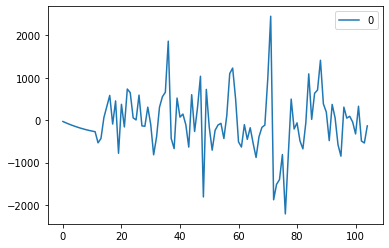

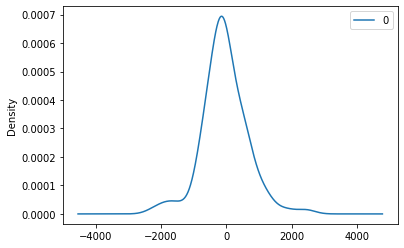

                 0
count   105.000000
mean    -51.749217
std     693.109824
min   -2212.977996
25%    -432.586225
50%    -109.533460
75%     321.878488
max    2452.227923


In [ ]:
train, test = series[0:size], series[size:len(series)]
model_fit = ExponentialSmoothing(history ,seasonal_periods=12 ,trend='add', seasonal='add').fit()
print(model_fit.summary())
""" plot residuals errors """
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
""" Hybrid Model """

window_size = 50

def make_model(window_size):
    model = Sequential()
    model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(window_size,1)))
    model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

lstm_model = make_model(50)

min_max_scaler = preprocessing.MinMaxScaler()
train = np.array(residuals).reshape(-1,1)
train_scaled = min_max_scaler.fit_transform(residuals) 

train_X,train_Y = [],[]
for i in range(0 , len(train_scaled) - window_size):
    train_X.append(train_scaled[i:i+window_size])
    train_Y.append(train_scaled[i+window_size])

new_train_X,new_train_Y = [],[]
for i in train_X:
    new_train_X.append(i.reshape(-1))
for i in train_Y:
    new_train_Y.append(i.reshape(-1))
new_train_X = np.array(new_train_X)
new_train_X = np.reshape(new_train_X, (new_train_X.shape[0], new_train_X.shape[1], 1))
new_train_Y = np.array(new_train_Y)
lstm_model.fit(new_train_X,new_train_Y, epochs=300, batch_size=32, validation_split = .05)

Epoch 1/300
2/2 [==============================] - 2s 311ms/step - loss: 1.5251 - mae: 1.1565 - val_loss: 0.0289 - val_mae: 0.1557
Epoch 2/300
2/2 [==============================] - 0s 67ms/step - loss: 0.1515 - mae: 0.3248 - val_loss: 0.3533 - val_mae: 0.5908
Epoch 3/300
2/2 [==============================] - 0s 70ms/step - loss: 0.3264 - mae: 0.4990 - val_loss: 0.2579 - val_mae: 0.5045
Epoch 4/300
2/2 [==============================] - 0s 75ms/step - loss: 0.1981 - mae: 0.3757 - val_loss: 0.0706 - val_mae: 0.2606
Epoch 5/300
2/2 [==============================] - 0s 70ms/step - loss: 0.0759 - mae: 0.2269 - val_loss: 0.0061 - val_mae: 0.0609
Epoch 6/300
2/2 [==============================] - 0s 67ms/step - loss: 0.0526 - mae: 0.1655 - val_loss: 0.0073 - val_mae: 0.0722
Epoch 7/300
2/2 [==============================] - 0s 63ms/step - loss: 0.0707 - mae: 0.2050 - val_loss: 0.0168 - val_mae: 0.1217
Epoch 8/300
2/2 [==============================] - 0s 61ms/step - loss: 0.0784 - mae: 0.2

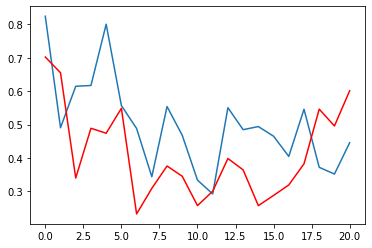

In [ ]:
test_extended = train.tolist()[-1*window_size:] + test_resid
test_data = []
for i in test_extended:
    try:
        test_data.append(i[0])
    except:
        test_data.append(i)
test_data = np.array(test_data).reshape(-1,1)
min_max_scaler = preprocessing.MinMaxScaler()
test_scaled = min_max_scaler.fit_transform(test_data)
test_X,test_Y = [],[]
for i in range(0 , len(test_scaled) - window_size):
    test_X.append(test_scaled[i:i+window_size])
    test_Y.append(test_scaled[i+window_size])
    new_test_X,new_test_Y = [],[]
for i in test_X:
    new_test_X.append(i.reshape(-1))
for i in test_Y:
    new_test_Y.append(i.reshape(-1))
new_test_X = np.array(new_test_X)
new_test_X = np.reshape(new_test_X, (new_test_X.shape[0], new_test_X.shape[1], 1))
new_test_Y = np.array(new_test_Y)
predictions = lstm_model.predict(new_test_X)
predictions_rescaled=min_max_scaler.inverse_transform(predictions)
Y = pd.DataFrame(new_test_Y)
pred = pd.DataFrame(predictions)
plt.plot(Y)
plt.plot(pred , color = 'r')
plt.show()
error = mse(test_resid,predictions_rescaled)

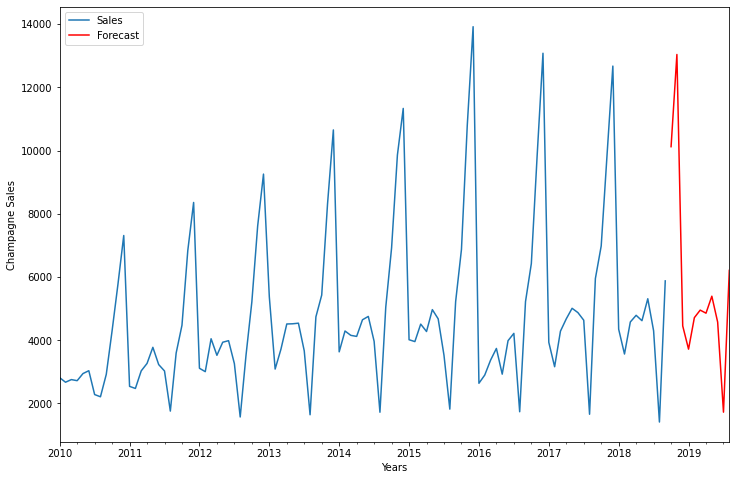

In [ ]:
Forecasting = model_fit.forecast(steps=12)
idx = pd.date_range(start='2018-09-01', periods=12, freq='MS')
Forecasting = pd.Series(Forecasting,index=idx)
axis = data.plot(label='Observed', figsize=(12, 8))
Forecasting[1:].plot(ax=axis, label='Forecast',color='r')
axis.set_xlabel('Years')
axis.set_ylabel('Champagne Sales')
plt.legend(loc='upper left')
plt.show()